This is another example of deploying a CNN, this time on a subset of the Kasthuri data set.  This example is essentially the same as that for ISBI 2012, with a few cosmetic differences.  This script assumes you have already run the kast-train-{synapse,membranes}.py scripts to train the CNN weights.

In [1]:
%matplotlib inline

import sys, os, os.path, copy, logging, socket, time

import numpy as np
import pylab as plt

import ndparse as ndp

try:
    logger
except:
    # do this precisely once
    logger = logging.getLogger("deploy_kast")
    logger.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter('[%(asctime)s:%(name)s:%(levelname)s]  %(message)s'))
    logger.addHandler(ch)

In [2]:
# note: the weight files choosen here are arbitrary.
w_membrane = os.path.join('membrane_weights', 'weights_epoch_001.h5') 
w_synapse = os.path.join('synapse_weights', 'weights_epoch_014.h5')

# load data (from local file - can replace with ndio call if desired)
data = np.load('deep_learning_kasthuri_example_data.npz')
X = data['Xtest']
X = np.transpose(X, [2, 0, 1]).astype(np.float32)
X = X[:,np.newaxis,:,:]

In [3]:
# In the interest of time, only deploy on one slice (z-dimension) of the test volume 
# *and* only evaluate a subset of the pixels in that slice.
#
# Note: depending upon your system (e.g. CPU vs GPU) this may take a few minutes...
#
tic = time.time()
P_membrane_0 = ndp.nddl.fit(X, w_membrane, slices=[0,], evalPct=.2, log=logger)
print("Time to deploy: %0.2f sec" % (time.time() - tic))

# The shape of the probability estimate tensor is:
#    (#slices, #classes, #rows, #cols)
print('Class probabilities shape: %s' % str(P_membrane_0.shape))

# Use a simple interpolation scheme to fill in "missing" values 
# (i.e. those pixels we did not evaluate using the CNN).

P_membrane_int_0 = ndp.nddl.interpolate_nn(P_membrane_0)

Using Theano backend.
[2016-11-10 00:50:41,528:deploy_kast:WARNING]  No output file specified - are you sure this is what you want?
[2016-11-10 00:50:41,549:deploy_kast:INFO]  X volume dimensions: (1, 1, 1024, 1024)
[2016-11-10 00:50:41,550:deploy_kast:INFO]  X values min/max:    0, 1
[2016-11-10 00:50:41,551:deploy_kast:INFO]  initializing CNN...
[2016-11-10 00:50:43,250:deploy_kast:INFO]  evaluating volume...
[2016-11-10 00:50:47,991:deploy_kast:INFO]  after masking, will evaluate 20.00% of data
[2016-11-10 00:50:49,688:deploy_kast:INFO]    last pixel [  0   0 494] (0.05% complete)
[2016-11-10 00:52:49,812:deploy_kast:INFO]    last pixel [ 0 83  4] (8.11% complete)
[2016-11-10 00:54:49,897:deploy_kast:INFO]    last pixel [  0 188 981] (18.45% complete)
[2016-11-10 00:56:50,148:deploy_kast:INFO]    last pixel [  0 279 803] (27.32% complete)
[2016-11-10 00:58:50,403:deploy_kast:INFO]    last pixel [   0  395 1012] (38.67% complete)
[2016-11-10 01:00:50,516:deploy_kast:INFO]    last pix

Time to deploy: 1114.83 sec
Class probabilities shape: (1, 2, 1024, 1024)


In [4]:
tic = time.time()
P_synapse_0 = ndp.nddl.fit(X, w_synapse, slices=[0,], evalPct=.2, log=logger)
print("Time to deploy (synapse): %0.2f sec" % (time.time() - tic))

# The shape of the probability estimate tensor is:
#    (#slices, #classes, #rows, #cols)
print('Class probabilities shape: %s' % str(P_synapse_0.shape))

# Use a simple interpolation scheme to fill in "missing" values 
# (i.e. those pixels we did not evaluate using the CNN).
# 
P_synapse_int_0 = ndp.nddl.interpolate_nn(P_synapse_0)

[2016-11-10 01:09:16,054:deploy_kast:WARNING]  No output file specified - are you sure this is what you want?
[2016-11-10 01:09:16,072:deploy_kast:INFO]  X volume dimensions: (1, 1, 1024, 1024)
[2016-11-10 01:09:16,074:deploy_kast:INFO]  X values min/max:    0, 1
[2016-11-10 01:09:16,074:deploy_kast:INFO]  initializing CNN...
[2016-11-10 01:09:16,183:deploy_kast:INFO]  evaluating volume...
[2016-11-10 01:09:19,454:deploy_kast:INFO]  after masking, will evaluate 20.00% of data
[2016-11-10 01:09:20,647:deploy_kast:INFO]    last pixel [  0   0 494] (0.05% complete)
[2016-11-10 01:11:20,722:deploy_kast:INFO]    last pixel [  0 132 823] (12.97% complete)
[2016-11-10 01:13:20,850:deploy_kast:INFO]    last pixel [  0 266 119] (25.99% complete)
[2016-11-10 01:15:20,997:deploy_kast:INFO]    last pixel [  0 399 926] (39.05% complete)
[2016-11-10 01:17:21,050:deploy_kast:INFO]    last pixel [  0 528 328] (51.59% complete)
[2016-11-10 01:19:21,517:deploy_kast:INFO]    last pixel [  0 623  44] (60.

Time to deploy (synapse): 1023.57 sec
Class probabilities shape: (1, 2, 1024, 1024)


After processing, there are 18 objects left.


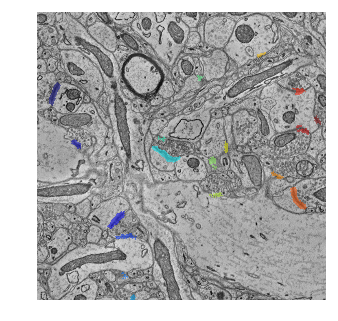

In [9]:
import ndparse as ndp

syn_prob = 1-P_synapse_int_0[0,0,...]
im = X[0,0,...]

ss = np.zeros((syn_prob.shape[0],syn_prob.shape[1],1))
ss[:,:,0] = syn_prob
syn = ndp.algorithms.basic_objectify(ss,threshold=0.9,min_size=200, max_size=10000, remove_speckle=50)
ndp.plot(im, syn, alpha=0.5)